In [1]:
from FAdo.fa import *
from FAdo.reex import *
from FAdo.fio import *
from FAdo.rndadfa import *

import lark

In [2]:
class CPower(Power):
	def __init__(self, arg, n, sigma=None):
		self.arg = arg
		self.n = n
		self.sigma = sigma
		super(CPower, self).__init__(arg, n, sigma)

	def linearForm(self):
		arg_lf = self.arg.linearForm()
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet())
				else:
					if self.n == 0:
						lf[head].add(CEmptySet())
					elif self.n == 1:
						lf[head].add(CEpsilon())
					else:
						lf[head].add(CPower(self.arg, self.n-1, self.sigma))

		return lf

	def partialDerivatives(self, sigma):
		return self.arg.partialDerivatives(sigma)

	def derivative(self, sigma):
		if self.n == 0:
			return CEmptySet()
		elif self.n == 1:
			return CEpsilon()
		else:
			return CPower(self.arg, self.n-1, sigma)

In [43]:
class CCount(Unary):
	def __init__(self, arg, min, max = None, sigma=None):
		self.arg = arg
		self.min = int(min)
		self.max = "inf" if max == -1 else int(max)-1
		self.Sigma = sigma
	
	def __str__(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')
	
	def _strP(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')

	def __repr__(self):
		"""Representation of the regular expression's syntactical tree."""
		return 'CCount({},[{}])'.format(self.arg, self.min if not self.max else '{},{}'.format(self.min, self.max))
	
	def epsilonP(self):
		if self.max == "inf" or self.max == None:
			return self.min == 0
		else:
			m_v = int(self.max)
			return self.min == 0 and m_v == 0
		
	def ewp(self):
		return False

	def emptysetP(self):
		return False
	
	def derivative(self, sigma):
		if self.max == "inf" or self.max == None:
			if self.min <= 0:
				return CEpsilon(sigma)
			elif self.min == 1:
				return CStar(self.arg, sigma)
			else:
				return CConcat(self.arg, CCount(self.arg, self.min-1, self.max, sigma), sigma)
		else:
			return CConcat(self.arg, CCount(self.arg, self.min-1, int(self.max)-1, sigma), sigma)

	def partialDerivatives(self, sigma):
		arg_pdset = self.arg.partialDerivatives(sigma)
		pds = set()
		for pd in arg_pdset:
			if pd.emptysetP():
				pds.add(CEmptySet(self.Sigma))
			elif pd.epsilonP():
				pds.add(self)
			else:
				pds.add(CConcat(pd, self, self.Sigma))
		return pds

	def linearForm(self): # https://www.dcc.fc.up.pt/~nam/resources/publica/51480046.pdf
		def nested(values):
			if not values:
				return None
			elif len(values) == 1:
				return values[0]
			else:
				return CDisj(values[0], nested(values[1:]))

		arg_lf = self.arg.linearForm()
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet(self.Sigma))
				# elif tail.epsilonP():
				# 	if self.max == "inf" or self.max == None:
				# 		if self.min - 1 == 0:
				# 			lf[head].add(CStar(self.arg, self.Sigma))
				# 		else:
				# 			lf[head].add(CCount(self.arg, self.min-1, self.max, self.Sigma))
				# 	else:
				# 		mav = int(self.max)
				# 		dist = mav - self.min
				# 		if dist == 0:
				# 			lf[head].add(self.arg)
				# 		else:
				# 			lf[head].add(CCount(self.arg, self.min if self.min==0 else self.min-1, mav-1, self.Sigma))

				# elif tail.epsilonP():
				# 	if mav-1 == self.min:
				# 		lf[head].add(CEpsilon())
				# 	elif mav-1 == self.min+1:
				# 		lf[head].add(self.arg)
				# 	else:
				# 		lf[head].add(CCount(self.arg, self.min, mav - 1, self.Sigma))
				elif tail.epsilonP():
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0:
							lf[head].add(CStar(self.arg, self.Sigma))
						else:
							#lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, self.max, self.Sigma), self.Sigma))
							lf[head].add(CConcat(CPower(self.arg, self.min-1, self.Sigma), CStar(self.arg, self.Sigma), self.Sigma))
						# if self.min - 1 == 0: #[n,m[
						# 	lf[head].add(CConcat(tail, CStar(self.arg), self.Sigma))
						# elif self.min - 1 == 1:
						# 	lf[head].add(CConcat(tail, self.arg, self.Sigma))
						# else:
						# 	lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, self.max, self.Sigma), self.Sigma))
					else:
						mav = int(self.max)
						lst = []
						for i in range(self.min-1, mav):
							if i > 0:
								lst.append(CPower(self.arg, i, self.Sigma))
							else:
								lst.append(CEpsilon(self.Sigma))

						lf[head].add(nested(lst))
				else:
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0:
							lf[head].add(CConcat(tail, CStar(self.arg, self.Sigma)))
						else:
							#lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, self.max, self.Sigma), self.Sigma))
							lf[head].add(CConcat(tail, CConcat(CPower(self.arg, self.min-1, self.Sigma), CStar(self.arg, self.Sigma), self.Sigma)))
						# if self.min - 1 == 0: #[n,m[
						# 	lf[head].add(CConcat(tail, CStar(self.arg), self.Sigma))
						# elif self.min - 1 == 1:
						# 	lf[head].add(CConcat(tail, self.arg, self.Sigma))
						# else:
						# 	lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, self.max, self.Sigma), self.Sigma))
					else:
						mav = int(self.max)
						lst = []
						for i in range(self.min, mav):
							lst.append(CPower(self.arg, i, self.Sigma))

						lf[head].add(CConcat(tail, nested(lst), self.Sigma))

						# if self.min - 1 == 0: #[n,m[
							
						# else:
						# 	lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, mav-1, self.Sigma), self.Sigma))


						
						# if mav-1 == self.min:
						# 	lf[head].add(CConcat(tail, CEpsilon(), self.Sigma))
						# elif mav-1 == self.min+1:
						# 	lf[head].add(CConcat(tail, self.arg, self.Sigma))
						# else:
						# 	lf[head].add(CConcat(tail, CCount(self.arg, self.min-1, mav - 1, self.Sigma), self.Sigma))

	# 	#print(lf)
					
		return lf

(b){4,}
{'b': {CConcat(Power(CAtom(b),3),CStar(CAtom(b)))}}


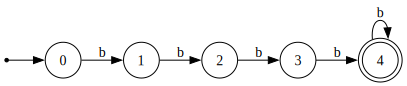

(b){4,}


In [53]:
class BuildRegexpCC(BuildRegexp):
    def pow_min(self, s, inf=False):
        (arg, n_r) = s
        n = int(n_r.children[0].value)
        if inf:
            if n == 0:
                r = CStar(arg, self.sigma)
            else:
                r = CCount(arg, n, -1, self.sigma)
        else:
            r = CPower(arg, n, self.sigma)

        r._ewp = True

        return r

    def pow_minmax(self, s):
        (arg, n_mi, n_ma) = s
        n_min = n_mi.children[0].value
        n_max = n_ma.children[0].value
        r = CCount(arg, n_min, n_max, self.sigma)
        r._ewp = True
        return r
    
    def pow_inf(self, s):
        return self.pow_min(s, True)
    
regGrammar = lark.Lark.open("regexp_test.lark", start="rege", parser="lalr")

# available:
# b^[1] -> 'b'
# b^[1,2] -> 1 <= 'b' <= 2
# b^[1,...] -> 1 <= 'b' <= inf

tree = regGrammar.parse("(b^[4,...[)")	
reg = BuildRegexpCC(context={"sigma": None}).transform(tree)
print(reg)
print(reg.linearForm())


reg.toNFA(nfa_method="nfaPDNaive").display()
print(reg)
#print(reg.derivative('b'))
#reg.partialDerivatives('b')


In [70]:
x = str2regexp("a*")
x.derivative("a")

CConcat(CEpsilon(),CStar(CAtom(a)))